**GAN Tutorial for MNIST Generation**

Taken & Modified from Yunjey Choi's Pytorch tutorial

https://github.com/yunjey/pytorch-tutorial

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64 # generator 입력 사이즈
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

In [3]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
#                                      std=(0.5, 0.5, 0.5))])
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])  # 원래는 0~1 인데 저렇게 정규화하면 -1~1로 됨 굳이 할 필요는 없음

# MNIST dataset
mnist = torchvision.datasets.MNIST(root=sample_dir,
                                   train=True, # test는 라벨 필요없어서 train만 불러옴
                                   transform=transform,
                                   download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 105589644.25it/s]


Extracting samples/MNIST/raw/train-images-idx3-ubyte.gz to samples/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21092755.32it/s]


Extracting samples/MNIST/raw/train-labels-idx1-ubyte.gz to samples/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27977359.65it/s]


Extracting samples/MNIST/raw/t10k-images-idx3-ubyte.gz to samples/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20617455.38it/s]


Extracting samples/MNIST/raw/t10k-labels-idx1-ubyte.gz to samples/MNIST/raw



In [4]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1), # output 1로 해서 진짜일 확률만 구함 0.99면 real, 0.01이면 fake
    nn.Sigmoid()) # 진짜일 확률 리턴

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()) # 데이터를 -1~1 사이로 해서 씀. 0~1 사이면 sigmoid 사용


# Device setting
D = D.to(device)
G = G.to(device)

In [5]:
criterion = nn.BCELoss() # binary cross entropy
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002) # GAN 할때는 lr 설정이 까다로움. 튜닝 잘 해야함
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


def denorm(x):
    out = (x + 1) / 2 # 정규화할때 x - 0.5 / 0.5 했으니까 복원한 것
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()



In [6]:

# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device) # (100, 784)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs # fake_score 점수가 올라가는지 보려고 저장
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs # fake_score 점수가 올라가는지 보려고 저장
        
        # Backprop and optimize 1 batch size 만큼 discriminator만 훈련
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images) # 가짜로 판별이 되어야함
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # 진짜가 되도록 속이도록 loss 구성
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))


Epoch [0/200], Step [200/600], d_loss: 0.0458, g_loss: 3.9416, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [400/600], d_loss: 0.0447, g_loss: 5.5281, D(x): 0.99, D(G(z)): 0.03
Epoch [0/200], Step [600/600], d_loss: 0.0332, g_loss: 5.6958, D(x): 0.98, D(G(z)): 0.01
Epoch [1/200], Step [200/600], d_loss: 0.0413, g_loss: 5.1456, D(x): 0.98, D(G(z)): 0.02
Epoch [1/200], Step [400/600], d_loss: 0.1474, g_loss: 3.4863, D(x): 0.94, D(G(z)): 0.04
Epoch [1/200], Step [600/600], d_loss: 0.1654, g_loss: 6.3173, D(x): 0.93, D(G(z)): 0.05
Epoch [2/200], Step [200/600], d_loss: 0.4463, g_loss: 2.9050, D(x): 0.86, D(G(z)): 0.14
Epoch [2/200], Step [400/600], d_loss: 0.3081, g_loss: 4.2270, D(x): 0.85, D(G(z)): 0.05
Epoch [2/200], Step [600/600], d_loss: 0.0591, g_loss: 6.4481, D(x): 0.98, D(G(z)): 0.04
Epoch [3/200], Step [200/600], d_loss: 0.7631, g_loss: 2.2061, D(x): 0.81, D(G(z)): 0.27
Epoch [3/200], Step [400/600], d_loss: 1.2955, g_loss: 1.8636, D(x): 0.60, D(G(z)): 0.20
Epoch [3/200], Step [

Generated Images


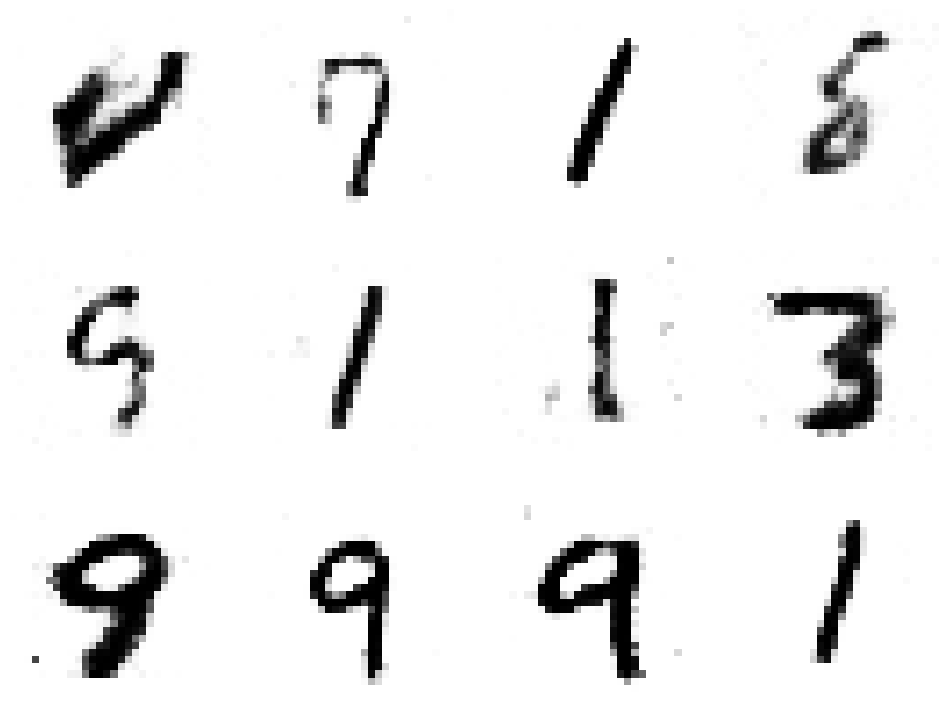

In [7]:
# Display generated images
import matplotlib.pyplot as plt


print('Generated Images')
plt.figure(figsize=(12, 12))
for k in range(12):
    plt.subplot(4, 4, k + 1)

    # Generate an image
    z = torch.randn(1, latent_size).to(device) # 가우시안 랜덤 z
    gen_img = G(z) # 이미지 생성

    # Display
    plt.imshow(gen_img.detach().cpu().numpy().reshape(28, 28),cmap='Greys')
    plt.axis('off')
    
plt.show()